In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

Цели:
- Сравнить средние баллы за три сессии ЕГЭшников и Олимпиадников, тем самым, ответив на вопрос: стоит ли готовиться к олимпиадам, дают ли они преимущество при учебе в университете или можно просто готовиться к ЕГЭ.
- Обучить модель, которая предсказывала бы средний балл за три сессии по баллам ЕГЭ и наличию аттестата с отличием,	сочинения, золотого значка ГТО и права на общежитие.

Подписать на графиках цвет Егэшники Льготники

## 1) Обработка данных студентов

Импортируем файл с данными студентов:

In [28]:
Students = pd.read_csv('Students.csv', header = 0)

In [37]:
Students.shape

(381, 12)

In [43]:
Students.head()

,N зачетки,Ф И О,Экз.гр,оц,5,4,3,2,0,п/сдач,Балл,Рейт
0,3200617,Комарова Ирина Алексеевна,201,14,14,0,0,0,0,0,70,0
1,3200500,Тарасенков Александр Николаевич,201,14,14,0,0,0,0,0,70,0
2,3200330,Гордеев Артем Павлович,202,17,17,0,0,0,0,0,85,0
3,3200410,Михайлова Варвара Игоревна,202,17,17,0,0,0,0,0,85,0
4,3200400,Линовский Георгий Павлович,206,17,17,0,0,0,0,0,85,0


Видно, что количество оценок у учеников различается.

In [31]:
Students.value_counts('оц')

оц
17    336
14     22
12      5
16      5
11      4
15      4
10      2
13      2
5       1
dtype: int64

Большинство оценок равно 17.

Нормируем баллы:

In [44]:
Students['Балл'] = Students['Балл'] / Students['оц'] * 17
Students.head()

,N зачетки,Ф И О,Экз.гр,оц,5,4,3,2,0,п/сдач,Балл,Рейт
0,3200617,Комарова Ирина Алексеевна,201,14,14,0,0,0,0,0,85.0,0
1,3200500,Тарасенков Александр Николаевич,201,14,14,0,0,0,0,0,85.0,0
2,3200330,Гордеев Артем Павлович,202,17,17,0,0,0,0,0,85.0,0
3,3200410,Михайлова Варвара Игоревна,202,17,17,0,0,0,0,0,85.0,0
4,3200400,Линовский Георгий Павлович,206,17,17,0,0,0,0,0,85.0,0


Уберем столбцы, которые больше не понадобятся:

In [46]:
# Создаем таблицу с метрикой, которую мы будем объединять с таблицей EGE_Abiturients
Ball = Students.loc[ :, ['Ф И О', 'Балл']]
Ball.head()

,Ф И О,Балл
0,Комарова Ирина Алексеевна,85.0
1,Тарасенков Александр Николаевич,85.0
2,Гордеев Артем Павлович,85.0
3,Михайлова Варвара Игоревна,85.0
4,Линовский Георгий Павлович,85.0


Чтобы в дальнейшем объединить таблицу студентов с таблицей баллов ЕГЭ, изменим название столбца "Ф И О" на "Ф.И.О" и приведем имена к верхнему регистру:

In [47]:
Ball['Ф И О'] = Ball['Ф И О'].str.upper()

Ball.rename(columns={'Ф И О': 'Ф.И.О'}, inplace=True)

Ball.head()

,Ф.И.О,Балл
0,КОМАРОВА ИРИНА АЛЕКСЕЕВНА,85.0
1,ТАРАСЕНКОВ АЛЕКСАНДР НИКОЛАЕВИЧ,85.0
2,ГОРДЕЕВ АРТЕМ ПАВЛОВИЧ,85.0
3,МИХАЙЛОВА ВАРВАРА ИГОРЕВНА,85.0
4,ЛИНОВСКИЙ ГЕОРГИЙ ПАВЛОВИЧ,85.0


## 2) Обработка данных абитуриентов

Импортируем файл с данными абитуриентов:

In [76]:
Abiturients = pd.read_csv('Abiturients.csv', header = 0)

In [77]:
Abiturients.shape

(419, 11)

In [78]:
Abiturients.head()

,Ф.И.О,Льготы,Сумма баллов,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
0,БАБУШКИН КИРИЛЛ ПАВЛОВИЧ,NaN,305.0,81.0,64.0,76.0,82.0,0.0,2.0,0.0,Нет
1,СЕДЕНЬ АНТОН СЕРГЕЕВИЧ,NaN,297.0,39.0,81.0,82.0,87.0,6.0,2.0,0.0,Да
2,УВАРИЧЕВ МАКСИМ БОРИСОВИЧ,NaN,296.0,47.0,76.0,76.0,87.0,6.0,2.0,2.0,Нет
3,ВЫСОТИН СТЕПАН АЛЕКСЕЕВИЧ,NaN,248.0,36.0,62.0,80.0,70.0,0.0,0.0,0.0,Да
4,ЕФИМОВ РУСЛАН АЛЕКСАНДРОВИЧ,NaN,195.0,46.0,42.0,39.0,66.0,0.0,2.0,0.0,Нет


Посмотрим на стык абитуриентов с льготами и ЕГЭ:

In [79]:
Abiturients['Сумма баллов'].count(None)

125

In [80]:
Abiturients.iloc[[i for i in range(123, 129)]]

,Ф.И.О,Льготы,Сумма баллов,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
123,КАРАМНОВ МАКСИМ ИГОРЕВИЧ,NaN,348.0,100.0,97.0,76.0,73.0,0.0,2.0,0.0,Нет
124,ФЕДОТОВА АНАСТАСИЯ ЕВГЕНЬЕВНА,NaN,347.0,69.0,97.0,88.0,91.0,0.0,2.0,0.0,Да
125,ВАХОНИН АРТЕМИЙ АНДРЕЕВИЧ,Призер Всероссийской олимпиады школьников,NaN,NaN,NaN,NaN,NaN,6.0,2.0,0.0,Нет
126,NaN,Призер олимпиады № 36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,ТАРАСЕНКОВ АЛЕКСАНДР НИКОЛАЕВИЧ,Призер Всероссийской олимпиады школьников,NaN,NaN,NaN,NaN,NaN,6.0,2.0,0.0,Нет
128,ГОРАН АРСЕНИЙ ПАВЛОВИЧ,Победитель Всероссийской олимпиады школьников,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,Да


Как оказалось, у абитуриентов с несколькими олимпиадами вторая и т.д. олимпиады выносятся в отдельную строку. Эти строки нам не нужны, удалим их:

In [89]:
Abiturients = Abiturients.dropna(thresh=2)

In [90]:
Abiturients.shape

(343, 11)

Приведем к бинарному виду столбцы: "Право на общежитие", "ГТО", "Сочинение, "Аттестат с отличием":

In [93]:
Abiturients = Abiturients.replace({'Право на общежитие':{'Да':1, 'Нет':0}, 'ГТО':{2:1},
                                   'Сочинение':{2:1}, 'Аттестат с отличием':{6:1}})
Abiturients.head()

,Ф.И.О,Льготы,Сумма баллов,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
0,БАБУШКИН КИРИЛЛ ПАВЛОВИЧ,NaN,305.0,81.0,64.0,76.0,82.0,0.0,1.0,0.0,0
1,СЕДЕНЬ АНТОН СЕРГЕЕВИЧ,NaN,297.0,39.0,81.0,82.0,87.0,1.0,1.0,0.0,1
2,УВАРИЧЕВ МАКСИМ БОРИСОВИЧ,NaN,296.0,47.0,76.0,76.0,87.0,1.0,1.0,1.0,0
3,ВЫСОТИН СТЕПАН АЛЕКСЕЕВИЧ,NaN,248.0,36.0,62.0,80.0,70.0,0.0,0.0,0.0,1
4,ЕФИМОВ РУСЛАН АЛЕКСАНДРОВИЧ,NaN,195.0,46.0,42.0,39.0,66.0,0.0,1.0,0.0,0


Разобьем таблицу абитуриентов на две таблицы: абитуриентов с льготами и абитуриентов с баллами ЕГЭ:

In [99]:
EGE_Abiturients = Abiturients[:125]
Lgoti_Abiturients = Abiturients[125:]

Уберем в EGE_Abiturients столбец "Льготы" и "Сумма баллов", а в  Lgoti_Abiturients столбцы с баллами ЕГЭ и столбец "Сумма баллов":

In [100]:
EGE_Abiturients = EGE_Abiturients.drop(['Льготы', 'Сумма баллов'], axis = 1)
EGE_Abiturients.head()

,Ф.И.О,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
0,БАБУШКИН КИРИЛЛ ПАВЛОВИЧ,81.0,64.0,76.0,82.0,0.0,1.0,0.0,0
1,СЕДЕНЬ АНТОН СЕРГЕЕВИЧ,39.0,81.0,82.0,87.0,1.0,1.0,0.0,1
2,УВАРИЧЕВ МАКСИМ БОРИСОВИЧ,47.0,76.0,76.0,87.0,1.0,1.0,1.0,0
3,ВЫСОТИН СТЕПАН АЛЕКСЕЕВИЧ,36.0,62.0,80.0,70.0,0.0,0.0,0.0,1
4,ЕФИМОВ РУСЛАН АЛЕКСАНДРОВИЧ,46.0,42.0,39.0,66.0,0.0,1.0,0.0,0


In [102]:
Lgoti_Abiturients = Lgoti_Abiturients.drop(['ФИЗИКА(ДВИ)', 'Сумма баллов', 'ФИЗИКА(ЕГЭ)',
                                            'МАТЕМАТИКА(ЕГЭ)', 'РУССКИЙ ЯЗЫК(ЕГЭ)'], axis = 1)
Lgoti_Abiturients.head()

,Ф.И.О,Льготы,Аттестат с отличием,Сочинение,ГТО,Право на общежитие
125,ВАХОНИН АРТЕМИЙ АНДРЕЕВИЧ,Призер Всероссийской олимпиады школьников,1.0,1.0,0.0,0
127,ТАРАСЕНКОВ АЛЕКСАНДР НИКОЛАЕВИЧ,Призер Всероссийской олимпиады школьников,1.0,1.0,0.0,0
128,ГОРАН АРСЕНИЙ ПАВЛОВИЧ,Победитель Всероссийской олимпиады школьников,0.0,1.0,0.0,1
129,ОСТАПОВИЧ ДМИТРИЙ СЕРГЕЕВИЧ,Призер Всероссийской олимпиады школьников,1.0,1.0,0.0,0
130,ГОРДЕЕВ АРТЕМ ПАВЛОВИЧ,Призер Всероссийской олимпиады школьников,0.0,1.0,0.0,1


## 3) Анализ данных

In [108]:
print('Количество абитуриентов = ' + str(len(Abiturients)))
print('Количество абитуриентов с льготами = ' + str(len(Lgoti_Abiturients)))
print('Количество абитуриентов с баллами ЕГЭ = ' + str(len(EGE_Abiturients)))

Количество абитуриентов = 343
Количество абитуриентов с льготами = 218
Количество абитуриентов с баллами ЕГЭ = 125


Сопоставим таблицу абитуриентов с таблицей с баллами за три сессии чтобы узнать, кто лучше учится Егэшники или Льготники:

In [144]:
Lgoti_df = Lgoti_Abiturients.merge(Ball)
EGE_df = EGE_Abiturients.merge(Ball)

In [145]:
print(Lgoti_df.shape)
print(EGE_df.shape)

(191, 7)
(109, 10)


После совмещения таблиц абитуриентов и студентов, размеры таблиц уменьшились на количество исключенных/ушедших в академический отпуск/переведенных в другой вуз людей. Посчитаем количество отстраненных от учебы студентов:

In [146]:
print('Количество людей, поступавших по льготам, отсраненных от учебы = ' + str(len(Lgoti_Abiturients) - Lgoti_df.shape[0]))
print('Количество людей, поступавших по ЕГЭ, отсраненных от учебы = ' + str(len(EGE_Abiturients) - EGE_df.shape[0]))

print('Количество людей, поступавших по льготам, отсраненных от учебы в процентах = ' + str((len(Lgoti_Abiturients) - Lgoti_df.shape[0]) / Lgoti_df.shape[0]))
print('Количество людей, поступавших по ЕГЭ, отсраненных от учебы в процентах = ' + str((len(EGE_Abiturients) - EGE_df.shape[0]) / EGE_df.shape[0]))

Количество людей, поступавших по льготам, отсраненных от учебы = 27
Количество людей, поступавших по ЕГЭ, отсраненных от учебы = 16
Количество людей, поступавших по льготам, отсраненных от учебы в процентах = 0.14136125654450263
Количество людей, поступавших по ЕГЭ, отсраненных от учебы в процентах = 0.14678899082568808


Как оказалось, количество отстраненных студентов, несильно зависит от способа поступления в ВУЗ.

Проанализируем Льготников и Егэшников с помощью describe():

In [142]:
Lgoti_df.describe()

,Аттестат с отличием,Сочинение,ГТО,Право на общежитие,Балл
count,191.000000,191.0,191.000000,191.000000,191.000000
mean,0.376963,1.0,0.183246,0.670157,75.758742
std,0.485899,0.0,0.387885,0.471392,7.806466
min,0.000000,1.0,0.000000,0.000000,43.562500
25%,0.000000,1.0,0.000000,0.000000,72.000000
50%,0.000000,1.0,0.000000,1.000000,78.000000
75%,1.000000,1.0,0.000000,1.000000,81.178571
max,1.000000,1.0,1.000000,1.000000,85.000000


In [143]:
EGE_df.describe()

,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие,Балл
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,86.880734,92.706422,88.678899,92.055046,0.541284,0.981651,0.183486,0.596330,73.246068
std,11.062721,6.173874,6.382674,5.857624,0.500594,0.134829,0.388852,0.492899,8.820134
min,39.000000,64.000000,74.000000,73.000000,0.000000,0.000000,0.000000,0.000000,45.000000
25%,80.000000,91.000000,84.000000,89.000000,0.000000,1.000000,0.000000,0.000000,69.000000
50%,87.000000,93.000000,88.000000,94.000000,1.000000,1.000000,0.000000,1.000000,74.000000
75%,97.000000,97.000000,94.000000,96.000000,1.000000,1.000000,0.000000,1.000000,80.000000
max,100.000000,100.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,85.000000


- Средний балл Льготников (75.758742) немного больше, чем у Егэшников (73.246068)
- У Егэшников количество аттестатов с отличием (0.541284), в среднем, значительно больше, чем у Льготников (0.376963)
- Льготникам общежитие требуется чаще (0.670157), чем Егэшникам (0.596330)

Построим гистограмму баллов Егэшников и Льготников:

Text(0.5, 1.0, 'Гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

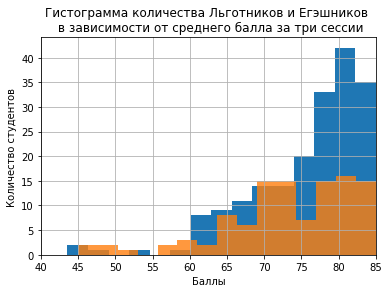

In [186]:
Lgoti_df.Балл.hist(bins = 15)
EGE_df.Балл.hist(bins = 15, alpha = 0.8)
plt.xlim(40, 85)

plt.xlabel('Баллы')
plt.ylabel('Количество студентов')
plt.title('Гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

Нормируем данные, чтобы стало проще сравнивать:

Text(0.5, 1.0, 'Гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

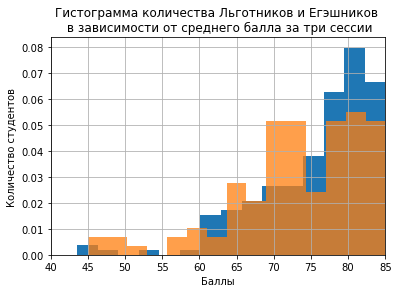

In [197]:
Lgoti_df.Балл.hist(bins = 15, density = True)
EGE_df.Балл.hist(bins = 15, alpha = 0.75, density = True)
plt.xlim(40, 85)

plt.xlabel('Баллы')
plt.ylabel('Количество студентов')
plt.title('Гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

Выводы из гистограммы:
- Количество Егэшников с баллом < 60 значительно больше, чем Льготников
- Льготников с баллами > 75 значительно больше, чем Льготников

## 4) Выбор лучшей модели

In [189]:
# Выделяем массив объектов
X = np.array(EGE_df[['ФИЗИКА(ДВИ)', 'ФИЗИКА(ЕГЭ)', 'МАТЕМАТИКА(ЕГЭ)', 'РУССКИЙ ЯЗЫК(ЕГЭ)','Аттестат с отличием',
                'Сочинение', 'ГТО', 'Право на общежитие']])

# Выделяем массив ответов
y = np.array(EGE_df['Балл'])

# Делим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

In [21]:
# Линейная регрессия

lr = LinearRegression().fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(lr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(lr.score(X_test, y_test)))

Правильность на обучающем наборе: 0.08
Правильность на тестовом наборе: 0.07


In [22]:
# Гребневая регрессия

ridge = Ridge(alpha=0.0001).fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(ridge.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(ridge.score(X_test, y_test)))

Правильность на обучающем наборе: 0.08
Правильность на тестовом наборе: 0.07


In [23]:
# Лассо регрессия

lasso001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Количество использованных признаков: {}".format(np.sum(lasso001.coef_ != 0)))
print()

for i, j in zip(df.columns[1:9], lasso001.coef_):
    print('Вес ' + str(i) + ' = ' + str(j))
# забавно что физика и дви по физике меньше всего влияют на то,
# какой будет средний балл

Правильность на обучающем наборе: 0.08
Правильность на тестовом наборе: 0.07
Количество использованных признаков: 8

Вес ФИЗИКА(ДВИ) = 0.1099923807928719
Вес ФИЗИКА(ЕГЭ) = 0.13179194340573833
Вес МАТЕМАТИКА(ЕГЭ) = 0.22212521153517906
Вес РУССКИЙ ЯЗЫК(ЕГЭ) = 0.18571339153869923
Вес Аттестат с отличием = 1.599147689291475
Вес Сочинение = 0.727689149175886
Вес ГТО = 0.37710040502822795
Вес Право на общежитие = -0.10957389013570505


In [24]:
# Ансамбль деревьев регрессии

forest = RandomForestRegressor(n_estimators=1000, random_state=15)
forest.fit(X_train, y_train)

print("Правильность на обучающем наборе: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(forest.score(X_test, y_test)))

# Прогноз на одного конкретного человека (MAX = 85)

# ВВЕДИТЕ ВАШИ ДАННЫЕ
# [0, 100]
FIZIKA_DVI = 100
FIZIKA_EGE = 100
MATEMATIKA_EGE = 100
RUSSKIY_YAZIK_EGE = 100

# 1 или 0
ATTESTAT_S_OTLICHIEM = 1
SOCHINENIE = 1
GTO = 1
# 192.34
OBSCHAGA = 0
# 780.75

Otvet = forest.predict([[FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                                                      ATTESTAT_S_OTLICHIEM, SOCHINENIE, GTO, OBSCHAGA]])

print('Ваш балл ЕГЭ:', sum([FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                            ATTESTAT_S_OTLICHIEM * 6, SOCHINENIE * 2, GTO * 2]))
print("Ваш средний балл:", Otvet)
print(float(Otvet/17))

Правильность на обучающем наборе: 0.863
Правильность на тестовом наборе: -0.592
Ваш балл ЕГЭ: 410
Ваш средний балл: [68.53035714]
4.031197478991595


In [25]:
# Градиентный бустинг деревьев регрессии

In [26]:
# Ядерный метод опорных векторов
# P.S. что-то он не работает, ответ практически не меняется 

svr = SVR()
svr.fit(X_train, y_train)

print("Правильность на обучающем наборе: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(forest.score(X_test, y_test)))

# Прогноз на одного конкретного человека (MAX = 85)

# ВВЕДИТЕ ВАШИ ДАННЫЕ
# [0, 100]
FIZIKA_DVI = 100
FIZIKA_EGE = 100
MATEMATIKA_EGE = 100
RUSSKIY_YAZIK_EGE = 100

# 1 или 0
ATTESTAT_S_OTLICHIEM = 1
SOCHINENIE = 1
GTO = 1
# 192.34
OBSCHAGA = 0
# 780.75

Otvet = svr.predict([[FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                                                      ATTESTAT_S_OTLICHIEM, SOCHINENIE, GTO, OBSCHAGA]])

print('Ваш балл ЕГЭ:', sum([FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                            ATTESTAT_S_OTLICHIEM * 6, SOCHINENIE * 2, GTO * 2]))
print("Ваш средний балл:", Otvet)
print(float(Otvet/17))

Правильность на обучающем наборе: 0.863
Правильность на тестовом наборе: -0.592
Ваш балл ЕГЭ: 410
Ваш средний балл: [75.28935329]
4.4287854878009485


In [175]:
# Нейронные сети

Neyr = MLPRegressor(random_state=89, activation = 'tanh', max_iter=10000, 
                    hidden_layer_sizes = [100, 100], alpha = 0.000099)
Neyr.fit(X_train, y_train)

print("Правильность на обучающем наборе: {:.3f}".format(Neyr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(Neyr.score(X_test, y_test)))


# Прогноз на одного конкретного человека (MAX = 85)

# ВВЕДИТЕ ВАШИ ДАННЫЕ
# [0, 100]
FIZIKA_DVI = 100
FIZIKA_EGE = 100
MATEMATIKA_EGE = 100
RUSSKIY_YAZIK_EGE = 100

# 1 или 0
ATTESTAT_S_OTLICHIEM = 1
SOCHINENIE = 1
GTO = 1
# 192.34
OBSCHAGA = 0
# 780.75

Otvet = Neyr.predict([[FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                                                      ATTESTAT_S_OTLICHIEM, SOCHINENIE, GTO, OBSCHAGA]])

print('Ваш балл ЕГЭ:', sum([FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                            ATTESTAT_S_OTLICHIEM * 6, SOCHINENIE * 2, GTO * 2]))
print("Ваш средний балл:", Otvet)
print(float(Otvet/17))

Правильность на обучающем наборе: 0.944
Правильность на тестовом наборе: -0.431
Ваш балл ЕГЭ: 410
Ваш средний балл: [81.85970178]
4.815276575210179


In [27]:
# Лассо регрессия
# Прогноз на одного конкретного человека (MAX = 85)

# ВВЕДИТЕ ВАШИ ДАННЫЕ
# [0, 100]
FIZIKA_DVI = 100
FIZIKA_EGE = 100
MATEMATIKA_EGE = 100
RUSSKIY_YAZIK_EGE = 100

# 1 или 0
ATTESTAT_S_OTLICHIEM = 1
SOCHINENIE = 1
GTO = 1
# 192.34
OBSCHAGA = 0
# 780.75

Otvet = lasso001.predict([[FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                                                      ATTESTAT_S_OTLICHIEM, SOCHINENIE, GTO, OBSCHAGA]])

print('Ваш балл ЕГЭ:', sum([FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                            ATTESTAT_S_OTLICHIEM * 6, SOCHINENIE * 2, GTO * 2]))
print("Ваш средний балл:", Otvet)
print(float(Otvet/17))

Ваш балл ЕГЭ: 410
Ваш средний балл: [80.97043695]
4.762966879258297


In [28]:
Иван:
Ваш балл ЕГЭ: 382
Ваш средний балл: [76.84389695]
4.52022923223318

Тимофей:
Ваш балл ЕГЭ: 325
Ваш средний балл: [68.9199664]
4.05411567079891

Сергей:
Ваш балл ЕГЭ: 353
Ваш средний балл: [71.8533564]
4.22666802380125

Я:
Ваш балл ЕГЭ: 366
Ваш средний балл: [71.5292374]
4.207602200242318

Рома:
Ваш балл ЕГЭ: 372
Ваш средний балл: [75.23746808]
4.425733416551874

Скороходов:
Ваш балл ЕГЭ: 389
Ваш средний балл: [77.04136379]
4.531844928820631

Никас:
Ваш балл ЕГЭ: 317
Ваш средний балл: [66.46246869]
3.909556981609843

Котик:
Ваш балл ЕГЭ: 322
Ваш средний балл: [68.21785857]
4.012815210113391

Юра:
Ваш балл ЕГЭ: 384
Ваш средний балл: [75.86540339]
4.462670787485763

Антон:
Ваш балл ЕГЭ: 355
Ваш средний балл: [71.21539079]
4.189140634620973

SyntaxError: invalid syntax (Temp/ipykernel_9264/904271824.py, line 1)